In [1]:
TRAIN =  '/kaggle/input/color-recognition-dataset-1500-samples/color_dataset/'

Let's load up our labels DataFrame and take a look.

In [2]:
import pandas as pd

DATA = '/kaggle/input/color-recognition-dataset-1500-samples/color_labels.csv'
df = pd.read_csv(filepath_or_buffer=DATA)
df.head()

,filename,color_code,rgb,hex,source_html
0,5D1046.png,5D1046,"75,159,181",#4b9fb5,blue.html
1,5P2223.png,5P2223,"219,237,236",#dbedec,blue.html
2,5T2224.png,5T2224,"178,225,229",#b2e1e5,blue.html
3,5P0136.png,5P0136,"146,214,223",#92d6df,blue.html
4,5D2226.png,5D2226,"99,180,198",#63b4c6,blue.html


Let's add some code that will get image embeddings for us using ResNeXt.

In [3]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np


DEVICE = torch.device('cpu')
OUTPUT_SIZE = 2048

model = models.resnext50_32x4d(weights=models.ResNeXt50_32X4D_Weights.IMAGENET1K_V2)

extraction_layer = model._modules.get('avgpool')
model.to(DEVICE)
model.eval()

scaler = transforms.Resize((224, 224))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()

def get_vec(arg, model, extraction_layer):
    image = normalize(to_tensor(scaler(arg))).unsqueeze(0).to(DEVICE)
    result = torch.zeros(1, OUTPUT_SIZE, 1, 1)
    def copy_data(m, i, o):
        result.copy_(o.data)
    hooked = extraction_layer.register_forward_hook(copy_data)
    with torch.no_grad():
        model(image)
    hooked.remove()
    return result

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-1a0047aa.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-1a0047aa.pth
100%|██████████| 95.8M/95.8M [00:01<00:00, 79.6MB/s]


Let's load up all of our data.

In [4]:
import arrow
import base64
import pandas as pd
from glob import iglob
from io import BytesIO
from os.path import basename
from os.path import isdir
from PIL import Image

THUMBNAIL_SIZE = (64, 64)

def embed(model, filename: str):
    with Image.open(fp=filename, mode='r') as image:
        return get_vec(arg=image.convert('RGB'), model=model, extraction_layer=extraction_layer).numpy().reshape(OUTPUT_SIZE,)


# https://stackoverflow.com/a/952952
def flatten(arg):
    return [x for xs in arg for x in xs]

def png(filename: str) -> str:
    with Image.open(fp=filename, mode='r') as image:
        buffer = BytesIO()
        # our images are pretty big; let's shrink the hover images to thumbnail size
        image.resize(size=THUMBNAIL_SIZE).convert('RGBA').save(buffer, format='png')
        return 'data:image/png;base64,' + base64.b64encode(buffer.getvalue()).decode()

def get_picture_from_glob(arg: str, tag: str,) -> list:
    time_get = arrow.now()
    result = [pd.Series(data=[tag, basename(input_file), embed(model=model, filename=input_file), png(filename=input_file)],
                        index=['tag', 'name', 'value', 'png'] )
        for index, input_file in enumerate(list(iglob(pathname=arg)))]
    print('encoded {} rows of {}  in {}'.format(len(result), tag, arrow.now() - time_get))
    return result

time_start = arrow.now()
train_dict = {basename(folder) : folder + '/*.*' for folder in iglob(TRAIN + '/*') if isdir(folder)}
train_df = pd.DataFrame(data=flatten(arg=[get_picture_from_glob(arg=value, tag=key) for key, value in train_dict.items()]))
train_df = train_df.merge(right=df, left_on='name', right_on='filename', how='inner')
train_df['source'] = train_df['source_html'].apply(func=lambda x: x.replace('.html', ''))
print('done in {}'.format(arrow.now() - time_start))

encoded 1577 rows of color_dataset  in 0:04:24.656604
done in 0:04:24.788442


We've added our source as a potential target variable. Is it balanced?

In [5]:
train_df['source'].value_counts(normalize=True).to_frame().T

source,earth_tone,green,voilet,blue,red,classic_neutrals,whispering_white,yellow,orange,dark_accents
proportion,0.296132,0.135067,0.11097,0.095117,0.084337,0.079264,0.063412,0.056436,0.047559,0.031706


No not really; we have ten classes, and our largest class is thirty percent of our data, leaving only three percent for our smallest class. 

Let's use TSNE to add x/y coordinates based on our image embeddings. It may seem like we've gone to a lot of trouble to get here, but this will give us a clustering we can easily visualize.

In [6]:
from sklearn.manifold import TSNE

train_reducer = TSNE(random_state=2025, verbose=True, n_jobs=1, perplexity=20.0, init='pca')
train_df[['x', 'y']] = train_reducer.fit_transform(X=train_df['value'].apply(func=pd.Series))

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 1577 samples in 0.010s...
[t-SNE] Computed neighbors for 1577 samples in 0.401s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1577
[t-SNE] Computed conditional probabilities for sample 1577 / 1577
[t-SNE] Mean sigma: 0.517847
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.737549
[t-SNE] KL divergence after 1000 iterations: 0.646345


Now let's plot based on our x/y coordinates and color based on our classes.

In [7]:
from bokeh.models import ColumnDataSource
from bokeh.models import HoverTool

from bokeh.plotting import figure
from bokeh.plotting import output_notebook
from bokeh.plotting import show
from bokeh.palettes import Turbo256
from bokeh.transform import factor_cmap

output_notebook()

datasource = ColumnDataSource(train_df[['png', 'source', 'x', 'y']].sample(n=min(7500, len(train_df)-1), random_state=2025))
factor_count = max(train_df['source'].nunique(), 3)
indices = np.linspace(0, len(Turbo256)-1, factor_count, dtype=int)
palette = [Turbo256[index] for index in indices]
mapper = factor_cmap(field_name = 'source', palette=palette, factors=train_df['source'].unique().tolist(), start=0, end=factor_count-1, )

plot_figure = figure(title='TSNE projection: colors', width=1000, height=800, tools=('pan, wheel_zoom, reset'))

plot_figure.add_tools(HoverTool(tooltips="""
<div>
    <div>
        <img src='@png' style='float: left; margin: 5px 5px 5px 5px'/>
    </div>
    <div>
        <span style='font-size: 18px'>@source</span>
    </div>
</div>
"""))

plot_figure.scatter(x='x', y='y', source=datasource, line_alpha=0.6, fill_alpha=0.6, size=8, color=mapper)
show(plot_figure)

Loading BokehJS ...

What do we see? TSNE does a good job of clustering similar colors together, but the clusters don't align to our classes especially well. Let's build a model and see how it does.

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_df['value'].apply(pd.Series), train_df['source'], test_size=0.25, random_state=2025, stratify=train_df['source'])
logreg = LogisticRegression(max_iter=2000, tol=1e-12).fit(X_train, y_train)
print('model fit in {} iterations'.format(logreg.n_iter_[0]))
print('accuracy: {:5.4f}'.format(accuracy_score(y_true=y_test, y_pred=logreg.predict(X=X_test))))
print('f1: {:5.4f}'.format(f1_score(average='weighted', y_true=y_test, y_pred=logreg.predict(X=X_test))))
print(classification_report(y_true=y_test, y_pred=logreg.predict(X=X_test), zero_division=0.0))

model fit in 1326 iterations
accuracy: 0.8177
f1: 0.8063
                  precision    recall  f1-score   support

            blue       0.97      0.87      0.92        38
classic_neutrals       0.74      0.84      0.79        31
    dark_accents       0.00      0.00      0.00        13
      earth_tone       0.82      0.86      0.84       117
           green       0.80      0.85      0.83        53
          orange       0.68      0.68      0.68        19
             red       0.93      0.79      0.85        33
          voilet       0.85      0.91      0.88        44
whispering_white       0.68      0.84      0.75        25
          yellow       0.86      0.82      0.84        22

        accuracy                           0.82       395
       macro avg       0.73      0.75      0.74       395
    weighted avg       0.80      0.82      0.81       395



This takes forever, but the f1 isn't bad. Let's take a look at our model probabilities.

<Axes: xlabel='probability', ylabel='Count'>

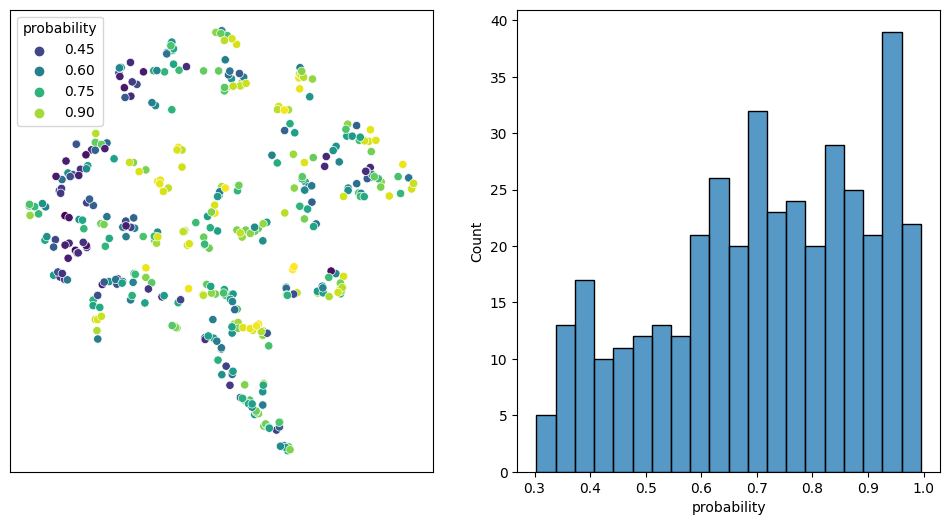

In [9]:
import matplotlib.pyplot as plt
import warnings
from seaborn import histplot
from seaborn import scatterplot

warnings.filterwarnings('ignore', category=FutureWarning, module='seaborn')

plot_df = train_df.iloc[X_test.index][['x', 'y']].copy()
plot_df['probability'] = np.max(logreg.predict_proba(X=X_test), axis=1)

fig, ax = plt.subplots(ncols=2, figsize=(12, 6))
scatterplot(ax=ax[0], data=plot_df, x='x', y='y', hue='probability', palette='viridis', )
ax[0].set(xlabel=None) 
ax[0].set(ylabel=None)
ax[0].set(xticklabels=[])
ax[0].set(yticklabels=[])
ax[0].tick_params(axis='both', which='both', length=0)
histplot(ax=ax[1], data=plot_df, x='probability', bins=20)

Our model probabilities are not especially high on average; this is a hard problem.

(-62.22279872894287, 68.39828624725342, -71.50022621154785, 56.24110908508301)

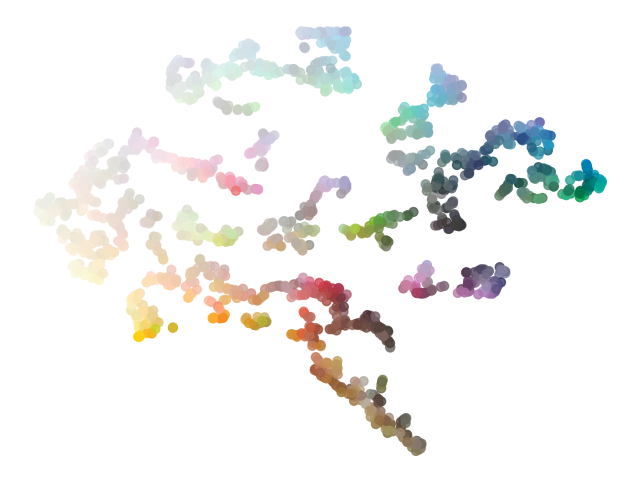

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
plt.scatter(train_df['x'], train_df['y'], c=train_df['hex'], s=40, alpha=0.8)
plt.axis('off')

And here is what our colors look like; TSNE has clustered the fainter colors on the left and the bolder colors on the right; it hasn't exactly clustered by RGB, has it?